## 1. Utils Module

In [48]:
# %load ../utils/utils.py
import numpy as np
import time


class DataLoader(object):
    @staticmethod
    def load_data_label(path: str):
        """
        this is for input file with (coordinate_x, coordinate_y, ... , label) in each line
        """
        with open(path, 'r') as f:
            data = []
            label = []
            for l in f.readlines():
                source = l.strip().split()
                data.append([float(val) for val in source[:-1]])
                label.append(int(source[-1]))
            return np.array(data), np.array(label)

    @staticmethod
    def load_data(path: str):
        """
        this is for input file with (coordinate_x, coordinate_y, ...) in each line
        """
        with open(path, 'r') as f:
            data = []
            for l in f.readlines():
                source = l.strip().split()
                data.append([float(val) for val in source])
            return np.array(data)


class Evaluation(object):
    @classmethod
    def silhouette_coefficient(cls, dbscan_obj):
        def a(pid, tags, dist_matrix):
            mask = tags == tags[pid]
            avg_dist = np.sum(dist_matrix[pid] * mask, axis=0) / np.sum(mask)
            return avg_dist

        def b(pid, tags, dist_matrix):
            avg_dists = []
            for label in range(1,
                               max(tags) + 1):  # cluster label starts from 1
                if label == tags[pid]:
                    continue
                mask = tags == label
                avg_dists.append(
                    np.sum(dist_matrix[pid] * mask, axis=0) / np.sum(mask))
            return min(avg_dists)

        # preparation
        # if sum(dbscan_obj.tags) == -dbscan_obj.num_p:
        if sum(dbscan_obj.tags) < 0:
            raise Exception('There are no tags in target dbscan method.')
        if not hasattr(dbscan_obj, 'dist_m'):
            # by default, we try to use matrix dbscan to tune parameters
            # BUG: If use basic dbscan has no _get_distance_matrix() attribute function
            dbscan_obj._get_distance_matrix()
        tags = np.array(dbscan_obj.tags)

        # TODO: this method still can be optimised by matrix computation
        res = 0
        for pid in range(dbscan_obj.num_p):
            tmp_a = a(pid, tags, dbscan_obj.dist_m)
            tmp_b = b(pid, tags, dbscan_obj.dist_m)
            res += (tmp_b - tmp_a) / max(tmp_b, tmp_a)
        res /= dbscan_obj.num_p

        print(
            f'eps: {dbscan_obj.eps} min points: {dbscan_obj.min_pts} silhouette coefficient: {res}'
        )
        return res


def timeit(func):
    def wrapper(*args, **wargs):
        start = time.time()
        res = func(*args, **wargs)
        end = time.time()
        print(f'{func.__name__} time cost: {round((end-start)*1000, 3)}ms')
        return res

    return wrapper


# Status
UNKNOWN = -1
NOISE = -2

## 2. Local DBSCAN Module

In [49]:
# %load ../serial/dbscan.py

class DBSCAN(object):
    """
    Base Class of DBSCAN, please do NOT instantiate this Class
    """

    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        """
        :param: dataset: numpy array or numpy matrix; set of data point coordinates 
        :param: eps: float; the value of radius of density area
        :param: min_pts: int; least neighbours should be in a density area
        :param: metric: str; the distance metric: (euclidian, manhattan, fast-euclidian)
        """
        self.m, _ = (dataset, None
                     )  # placeholder _ for future implementation of labels
        self.num_p = self.m.shape[0]
        self.tags = [UNKNOWN] * self.num_p
        self.is_core = [0] * self.num_p

        self.eps = eps**2 if metric == 'fast-euclidian' else eps
        self.min_pts = min_pts
        self.metric = metric

    def _get_dist(self, a, b) -> float:
        """
        for float comparison, set all distance value precision to 5
        :param: a: int; index of given point in data matrix
        :param: b: same as a
        """
        if self.metric == 'euclidian':
            result = np.sqrt(np.power(self.m[b] - self.m[a], 2).sum())
        elif self.metric == 'manhattan':
            result = np.abs(self.m[b] - self.m[a], 2).sum()
        elif self.metric == 'fast-euclidian':
            result = np.power(self.m[b] - self.m[a], 2).sum()
        else:
            raise Exception(f'Distance metric {self.metric} is invalid!')

        return round(result, 5)

    def _get_neighbours(self, p: int) -> list:
        """
        return neighbours index of given point p in source data matrix
        :param: p: int; index of given point in data matrix
        """
        pass

    def _clustering(self, p, cluster_id):
        """
        tag given point p and all of its neighbours and sub-neighbours with the same cluster id
        :param: m: np.matrix; N * 2 matrix recoding all nodes' coordinates
        :param: cluster_id: int; current id of cluster
        """
        pass

    def _find_core_pts(self):
        self.is_core = [0] * self.num_p
        for i in range(self.num_p):
            if len(self._get_neighbours(i)) > self.min_pts:
                self.is_core[i] = 1
        return self.is_core

    @timeit
    def predict(self) -> list:
        """
        return list of labels as the sequence in data matrix
        :param: m: np.matrix; N * 2 matrix recoding all nodes' coordinates
        :param: eps: float; the value of radius of density area
        :param: min_pts: int; least neighbours should be in a density area
        """

        cluster_id = 1
        for p_id in range(self.num_p):
            if self.tags[p_id] != UNKNOWN:
                continue
            if self._clustering(p_id, cluster_id):
                cluster_id += 1
        return np.array(self.tags)


class NaiveDBSCAN(DBSCAN):
    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        super(NaiveDBSCAN, self).__init__(dataset, eps, min_pts, metric)

    def _get_neighbours(self, p: int) -> list:

        ngbs = []
        for idx in range(len(self.m)):
            if self._get_dist(p, idx) < self.eps:
                ngbs.append(idx)
        return ngbs

    def _clustering(self, p, cluster_id) -> bool:

        neighbours = self._get_neighbours(p)
        if len(neighbours) < self.min_pts:
            self.tags[p] = NOISE
            return False
        else:
            self.tags[p] = cluster_id
            for idx in neighbours:
                self.tags[idx] = cluster_id
            while len(neighbours) > 0:
                sub_neighbours = self._get_neighbours(neighbours[0])
                if len(sub_neighbours) >= self.min_pts:
                    for sub_n in sub_neighbours:
                        if self.tags[sub_n] < 0:
                            self.tags[sub_n] = cluster_id
                            if self.tags[sub_n] == UNKNOWN:
                                neighbours.append(sub_n)
                neighbours = neighbours[1:]
        return True


class MatrixDBSCAN(DBSCAN):
    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        super(MatrixDBSCAN, self).__init__(dataset, eps, min_pts, metric)

    def _get_distance_matrix(self):
        """
        Only once calculation will be on each point-pairs
        results will be stored in self.dist_m
        """
        self.dist_m = np.zeros((self.num_p, self.num_p))
        for p_id in range(self.num_p):
            for q_id in range(p_id, self.num_p):
                dist = self._get_dist(p_id, q_id)
                self.dist_m[q_id, p_id] = dist
                self.dist_m[p_id, q_id] = dist

    def _get_neighbours(self, p: int) -> list:
        if not hasattr(self, 'dist_m'):
            self._get_distance_matrix()
        return np.nonzero(self.dist_m[p] < self.eps)[0]

    def _clustering(self, p, cluster_id) -> bool:
        """
        TODO: There should be some optimizations for this part, current code is too ugly
        """

        neighbours = self._get_neighbours(p)
        if len(neighbours) < self.min_pts:
            self.tags[p] = NOISE
            return False
        else:
            self.tags[p] = cluster_id
            for idx in neighbours:
                self.tags[idx] = cluster_id
            while len(neighbours) > 0:
                sub_neighbours = self._get_neighbours(neighbours[0])
                if len(sub_neighbours) >= self.min_pts:
                    for sub_n in sub_neighbours:
                        if self.tags[sub_n] < 0:
                            self.tags[sub_n] = cluster_id
                            if self.tags[sub_n] == UNKNOWN:
                                neighbours.append(sub_n)
                neighbours = neighbours[1:]
        return True


## 3. Parallel Implementation

In [50]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [51]:
def load_data_label(path):
    pts = sc.textFile(path).map(lambda x: x.strip().split()[:-1]).map(lambda x: tuple([float(i) for i in x]))
    return pts.collect()

def load_data(path):
    pts = sc.textFile(path).map(lambda x: x.strip().split()).map(lambda x: tuple([float(i) for i in x]))
    return pts.collect()

In [52]:
b_dataset = None
b_eps = None
b_min_pts = None


def _bounds_coordinates(bin_bounds):
#     coordinates = [bounds[0]]

    lower_cdnts = [[low] for low in  bin_bounds[0][:-1]]
    upper_cdnts = [[high] for high in bin_bounds[0][1:]]
    
    # super stupid implementation, optimization needed
    for bound in bin_bounds[1:]:
        lower_tmp = []
        upper_tmp = []
        
        for bc in bound[:-1]:
            lower_tmp.extend([lc + [bc] for lc in lower_cdnts])
        lower_cdnts = lower_tmp
        
        for bc in bound[1:]:
            upper_tmp.extend([uc + [bc] for uc in upper_cdnts])
        upper_cdnts = upper_tmp
        
    return np.array(lower_cdnts), np.array(upper_cdnts)

@timeit
def partition(dataset, n_partitions, eps):
    """
    n_partitions: tuple with shape correspoding to dataset dimension
    """
    partition_dim = n_partitions
    n_partitions = np.prod(n_partitions)
    # cut bins
    bounds = np.concatenate(([np.min(dataset, axis=0)], [np.max(dataset, axis=0)]), axis=0) # 2 * D
    bounds_dim = bounds.T # D * 2, 
    
    bin_bounds = []
    for i in range(len(partition_dim)):
        dim_bins = np.linspace(*bounds_dim[i], partition_dim[i]+1, endpoint=True)
        bin_bounds.append(dim_bins)
    
    lower_bounds, upper_bounds = _bounds_coordinates(bin_bounds)
    lower_bounds -= eps
    upper_bounds += eps
    
#     print(lower_bounds)
#     print(upper_bounds)
    
    # scatter points into bins with eps
    indexed_data = []
    for id_pts in range(len(dataset)):     # index of point in dataset
        for id_ptt in range(n_partitions):
            if not (dataset[id_pts] > lower_bounds[id_ptt]).all():
                continue
            if not (dataset[id_pts] < upper_bounds[id_ptt]).all():
                continue
            indexed_data.append([id_ptt, id_pts])
            
    res = sc.parallelize(indexed_data).groupByKey().map(lambda x: [x[0], list(x[1])])
    return res

def local_dbscan(partioned_rdd, method='matrix', metric='euclidian'):

    dataset = np.array([b_dataset.value[idp] for idp in partioned_rdd])
    if method == 'matrix':
        dbscan_obj = MatrixDBSCAN(dataset, eps, min_pts, metric) 
    else:
        dbscan_obj = NaiveDBSCAN(dataset, eps, min_pts, metric) 
    dbscan_obj.predict()
    is_core_list = dbscan_obj._find_core_pts()
    
    return list(zip(zip(partioned_rdd, is_core_list), dbscan_obj.tags))

@timeit
def merge(local_tags, dataset):
    global_tags = [UNKNOWN] * len(dataset)
    is_tagged = [0] * len(dataset)
    last_max_label = 0
    for local in local_tags:
        np_local = np.array(local[-1])
        np_local[:, -1] += last_max_label

        last_max_label = np.max(np_local[:, -1])
        
        # check and merge overlapped points
        tagged_indices = np.nonzero(is_tagged)[0]
        for tmp_i in range(len(np_local)):
            # should do tag check
            (p_id, is_core), label = np_local[tmp_i]
            if p_id in tagged_indices and is_core==1:
                np_local[-1][np_local[-1]==label] = global_tags[p_id]
        
        # update global tags
        for (p_id, is_core), label in np_local:
            if is_tagged[p_id]==1:
                continue
            global_tags[p_id] = label
            is_tagged[p_id] = 1
    return global_tags

# parallel entry function
@timeit
def parallel_dbscan(dataset, eps, min_pts, partition_tuple, method='matrix', metric='euclidian'):
    
#     b_dataset = sc.broadcast(dataset)
#     b_eps = sc.broadcast(eps)
#     b_min_pts = sc.broadcast(min_pts)
    
    partitioned_rdd = partition(dataset, n_partitions, eps)
    local_tags = partitioned_rdd.mapValues(lambda x: local_dbscan(x, method=method, metric=metric)).collect()
    result_tags = merge(local_tags, dataset)
    
    return result_tags

## 4. Plot Module

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib notebook

def plot_result(dataset, result_tags, file_name=None, style='ticks'):
    # data preparation
    dataset = np.array(dataset)
    df = pd.DataFrame()
    df['x'] = dataset[:, 0]
    df['y'] = dataset[:, 1]
    df['label'] = result_tags
    
    # sns preparation
#     sns.set_context("notebook", font_scale=1)
    sns.set_style(style)
    f, axes = plt.subplots(1, 2, sharex=True, sharey=True)
    
    sns.scatterplot('x', 'y',data=df, ax=axes[0], palette='Blues_d')
    sns.scatterplot('x', 'y', data=df, hue='label', ax=axes[1])
    
    plt.title(f'DBSCAN Result of {file_name}')
    plt.xlabel('x')
    plt.ylabel('y')
    
#     plt.legend(loc='upper right')
    plt.gca().get_legend().set_visible(False)

    plt.tight_layout()
    plt.show()

## 5. Test Playground

In [36]:
test_file = '../../data/shape-sets/r15_600.txt'
dataset = np.array(load_data_label(test_file))
n_partitions = (4, 2)
eps = 0.7
min_pts = 12

### 5.1 serial

predict time cost: 2058.7680339813232ms
eps: 0.7 min points: 12 silhouette coefficient: 0.7544791263199666


<IPython.core.display.Javascript object>


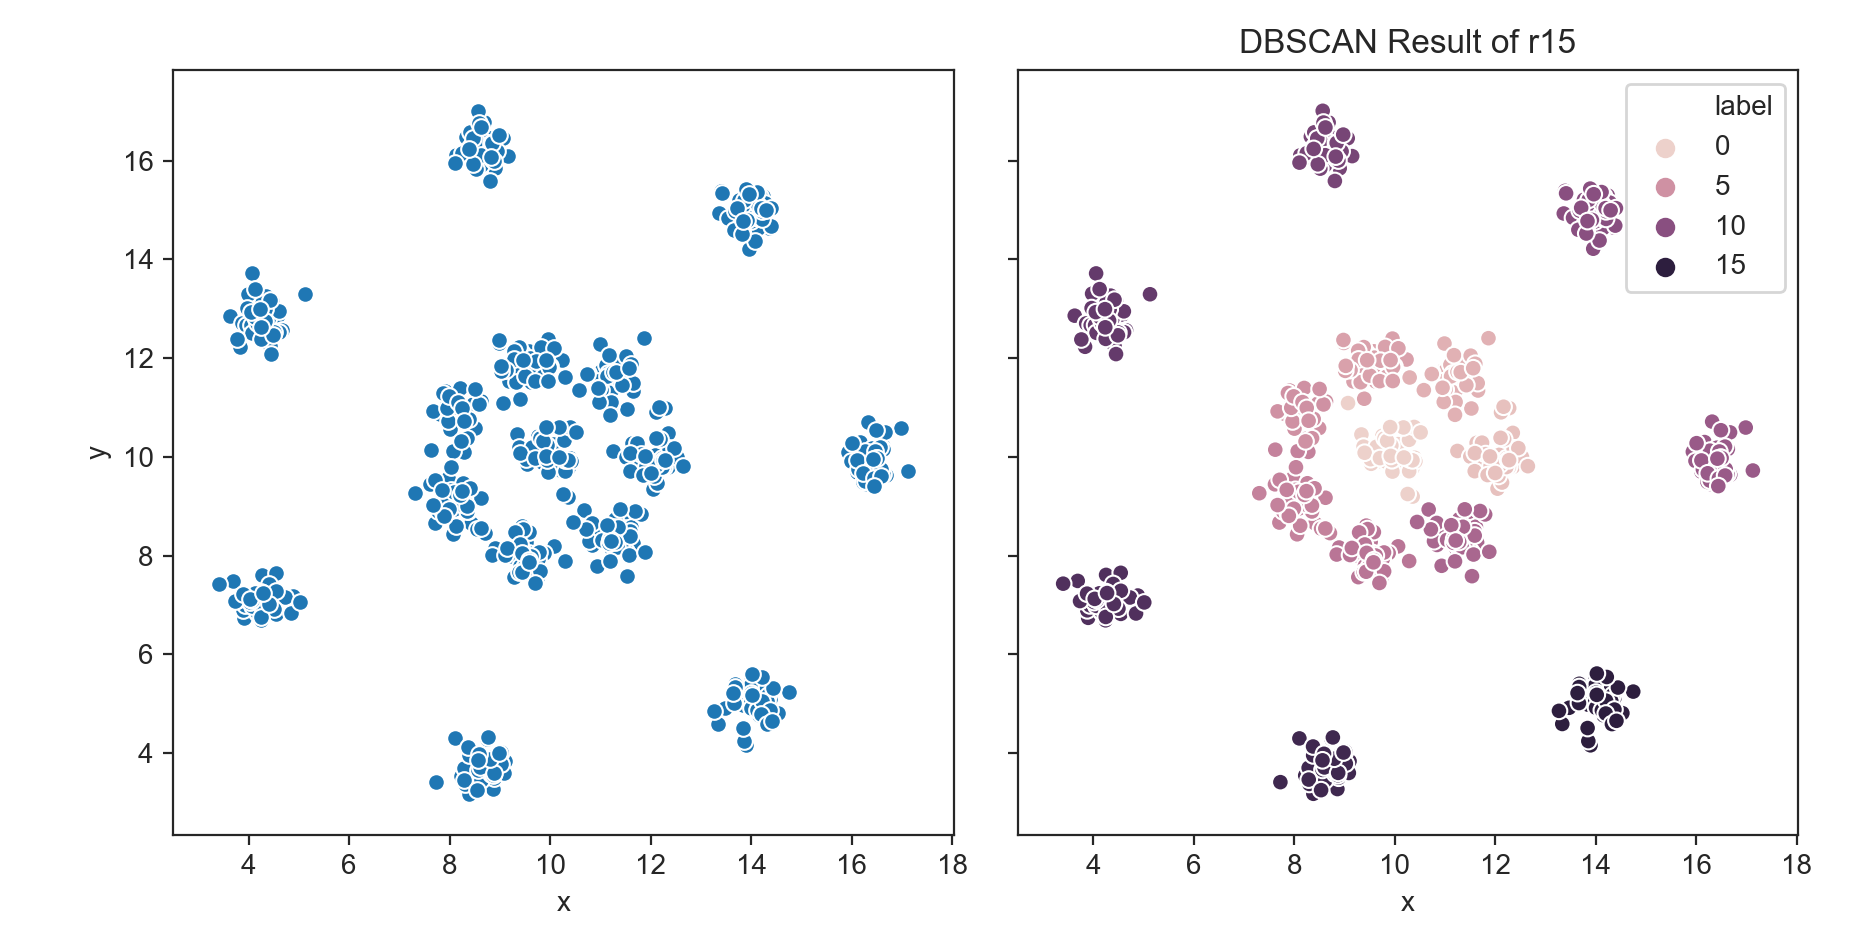

In [37]:
mdbscan = MatrixDBSCAN(dataset, eps, min_pts)
result_tags = mdbscan.predict()
Evaluation.silhouette_coefficient(mdbscan)
del mdbscan
plot_result(dataset, result_tags, 'r15')

### 5.2 parallel

In [60]:
test_file = '../../data/shape-sets/r15_600.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [4, 4], [4, 8]]
eps = 0.7
min_pts = 12
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

# serial naive
print('\nSERIAL:')
mdbscan = NaiveDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()

print('\nSERIAL:')
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
# Evaluation.silhouette_coefficient(mdbscan)

for n_partitions in n_partition_set:
    print(f'\nPartitions: {np.prod(n_partitions)}')
    # parallel naive dbscan
    print('\nNAIVE:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='naive', metric='euclidian')

    # parallel matrix dbscan
    print('\nMATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='euclidian')

    # parallel matrix dbscan
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian')
# dbscan_obj = MatrixDBSCAN(dataset, eps, min_pts)
# dbscan_obj.tags = result_tags
# dbscan_obj.eps = eps
# dbscan_obj.min_pts = min_pts
# Evaluation.silhouette_coefficient(dbscan_obj)


SERIAL:
predict time cost: 3180.224ms

SERIAL:
predict time cost: 2002.467ms

Partitions: 4

NAIVE:
partition time cost: 25.183ms
merge time cost: 5.085ms
parallel_dbscan time cost: 1130.666ms

MATRIX:
partition time cost: 20.527ms
merge time cost: 5.131ms
parallel_dbscan time cost: 370.118ms

FAST-MATRIX:
partition time cost: 21.163ms
merge time cost: 5.184ms
parallel_dbscan time cost: 341.084ms

Partitions: 8

NAIVE:
partition time cost: 28.285ms
merge time cost: 5.911ms
parallel_dbscan time cost: 753.046ms

MATRIX:
partition time cost: 28.641ms
merge time cost: 6.022ms
parallel_dbscan time cost: 291.845ms

FAST-MATRIX:
partition time cost: 29.144ms
merge time cost: 5.865ms
parallel_dbscan time cost: 275.496ms

Partitions: 16

NAIVE:
partition time cost: 43.332ms
merge time cost: 7.308ms
parallel_dbscan time cost: 567.159ms

MATRIX:
partition time cost: 45.496ms
merge time cost: 6.987ms
parallel_dbscan time cost: 260.233ms

FAST-MATRIX:
partition time cost: 41.781ms
merge time cost:

In [61]:
test_file = '../../data/shape-sets/d31_3100.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [4, 4], [4, 8]]
eps = 1.5
min_pts = 70
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

# serial naive
print('\nSERIAL:')
mdbscan = NaiveDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()

print('\nSERIAL:')
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
Evaluation.silhouette_coefficient(mdbscan)

for n_partitions in n_partition_set:
    print(f'\nPartitions: {np.prod(n_partitions)}')
    # parallel naive dbscan
    print('\nNAIVE:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='naive', metric='euclidian')

    # parallel matrix dbscan
    print('\nMATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='euclidian')

    # parallel matrix dbscan
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian')


SERIAL:
predict time cost: 87432.951ms

SERIAL:
predict time cost: 54923.143ms
eps: 1.5 min points: 70 silhouette coefficient: 0.5544115320852886

Partitions: 4

NAIVE:
partition time cost: 56.946ms
merge time cost: 23.098ms
parallel_dbscan time cost: 22376.276ms

MATRIX:
partition time cost: 54.496ms
merge time cost: 31.038ms
parallel_dbscan time cost: 6745.387ms

FAST-MATRIX:
partition time cost: 68.955ms
merge time cost: 31.357ms
parallel_dbscan time cost: 6258.88ms

Partitions: 8

NAIVE:
partition time cost: 97.598ms
merge time cost: 31.247ms
parallel_dbscan time cost: 15575.716ms

MATRIX:
partition time cost: 94.293ms
merge time cost: 32.526ms
parallel_dbscan time cost: 4166.107ms

FAST-MATRIX:
partition time cost: 95.655ms
merge time cost: 33.226ms
parallel_dbscan time cost: 3843.859ms

Partitions: 16

NAIVE:
partition time cost: 169.772ms
merge time cost: 46.59ms
parallel_dbscan time cost: 9711.102ms

MATRIX:
partition time cost: 178.872ms
merge time cost: 51.231ms
parallel_dbs

predict time cost: 53921.715ms


<IPython.core.display.Javascript object>


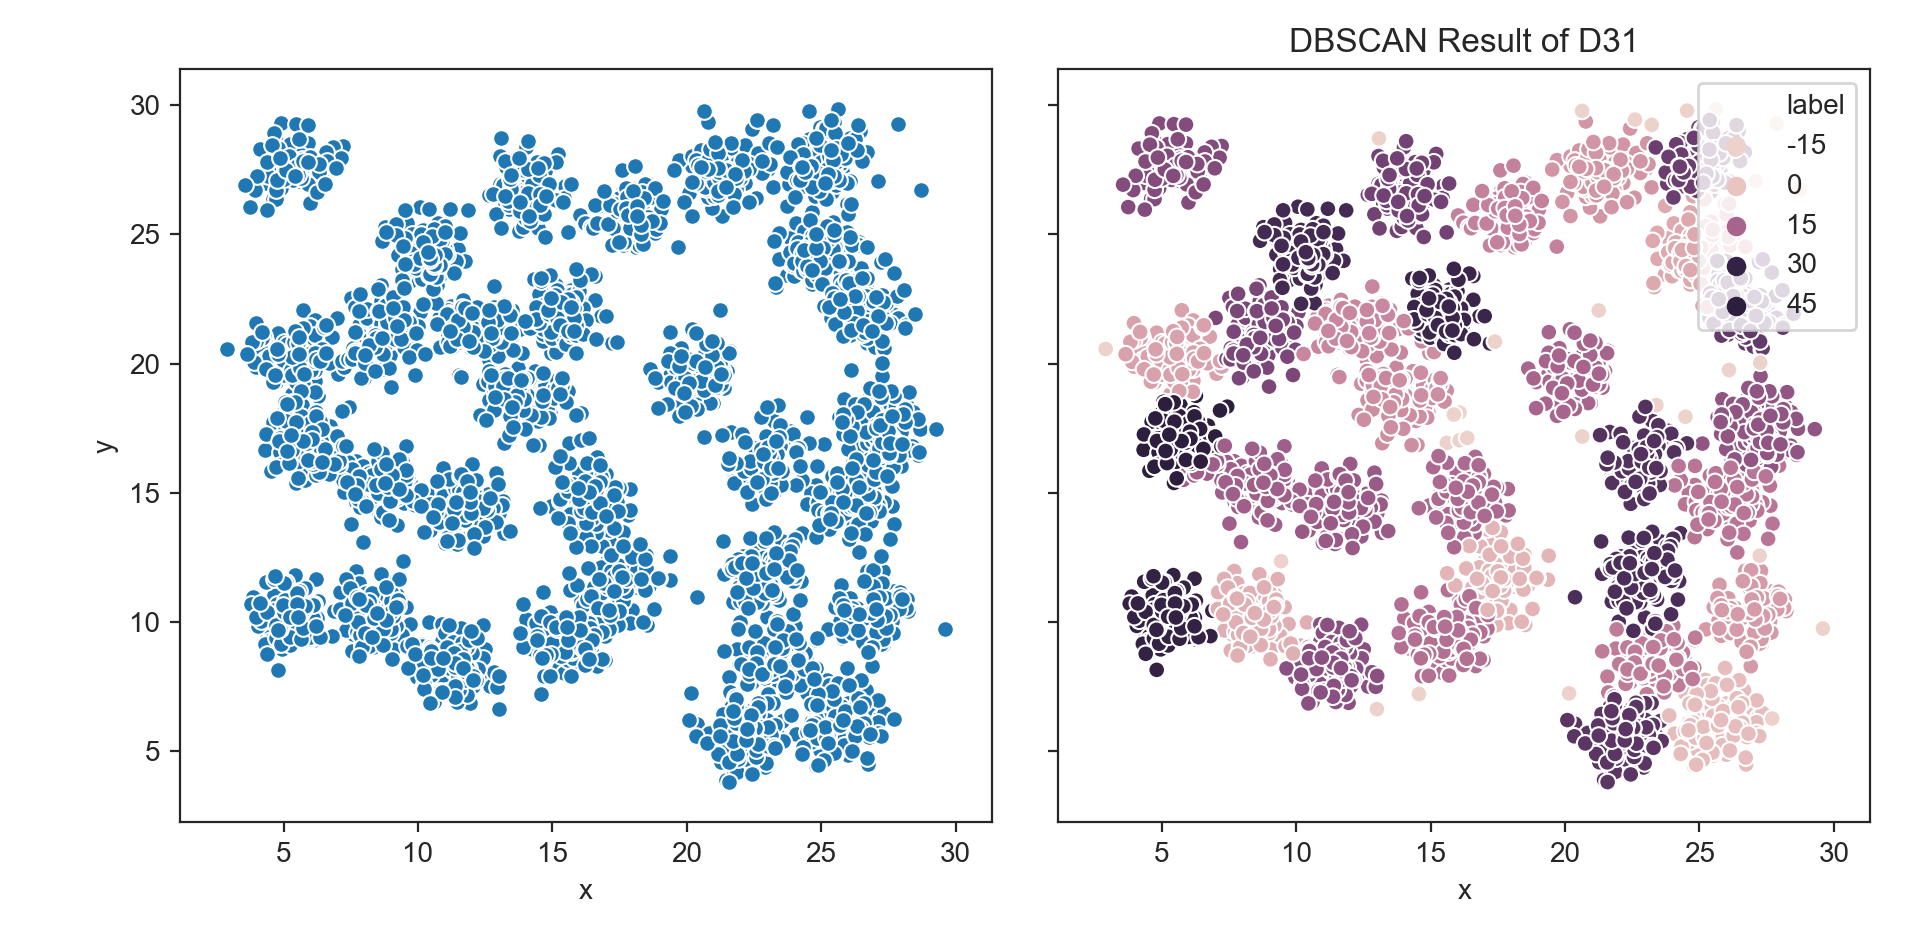

In [63]:
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
plot_result(dataset, result_tags, 'D31')

predict time cost: 838.929ms


<IPython.core.display.Javascript object>


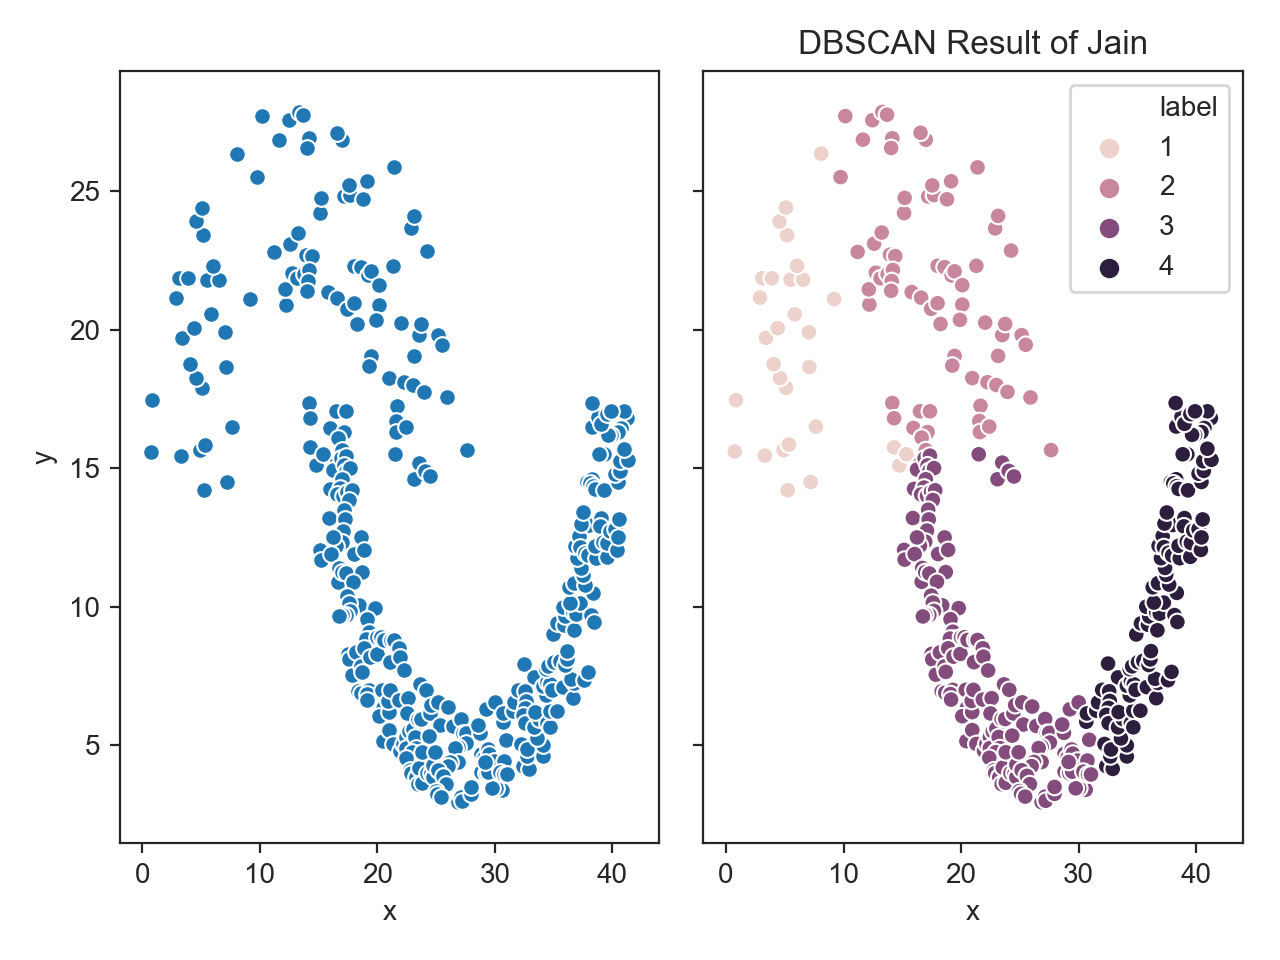

eps: 10 min points: 1 silhouette coefficient: 0.4667587236739983


0.4667587236739983

In [76]:
test_file = '../../data/shape-sets/jain_373.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [4, 4], [4, 8]]
eps = 10
min_pts = 1
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

# serial naive
print('\nSERIAL:')
mdbscan = NaiveDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()

print('\nSERIAL:')
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
# Evaluation.silhouette_coefficient(mdbscan)

for n_partitions in n_partition_set:
    print(f'\nPartitions: {np.prod(n_partitions)}')
    # parallel naive dbscan
    print('\nNAIVE:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='naive', metric='euclidian')

    # parallel matrix dbscan
    print('\nMATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='euclidian')

    # parallel matrix dbscan
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian')


predict time cost: 835.366ms


<IPython.core.display.Javascript object>


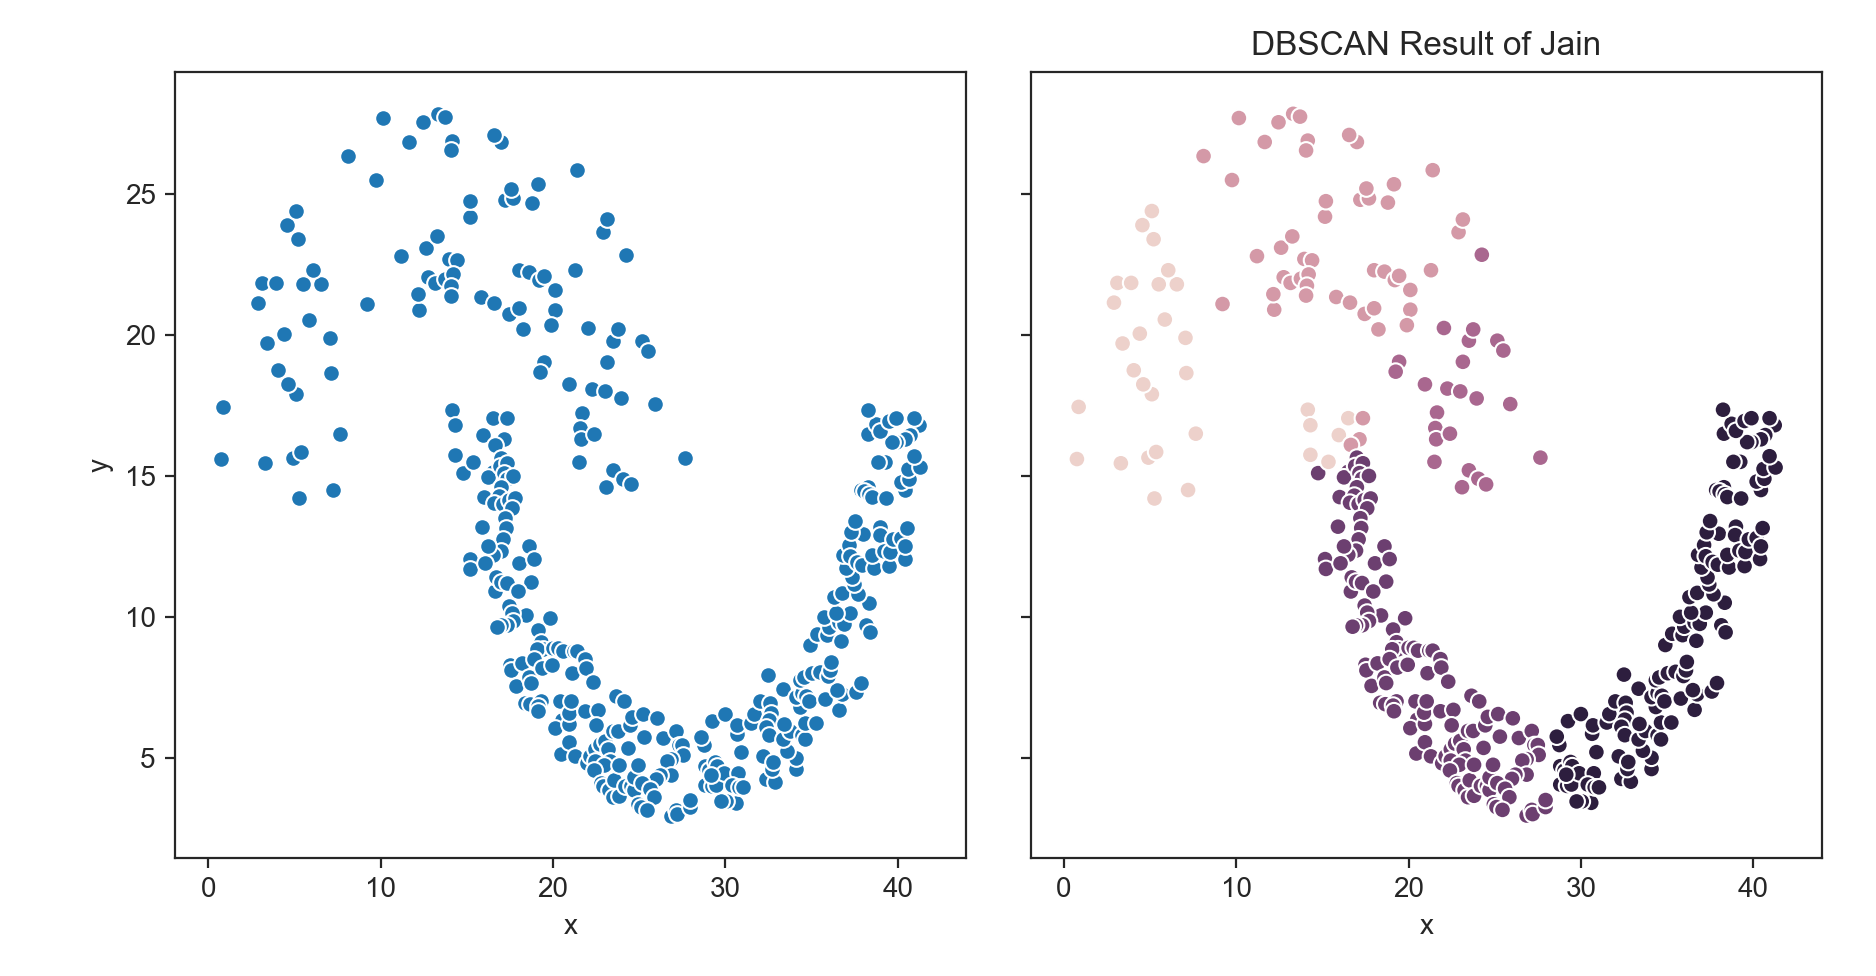

eps: 9 min points: 3 silhouette coefficient: 0.43391595150895496


0.43391595150895496

In [103]:
test_file = '../../data/shape-sets/jain_373.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [4, 4], [4, 8]]
eps = 9
min_pts = 3
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
plot_result(dataset, result_tags, 'Jain')
Evaluation.silhouette_coefficient(mdbscan)


In [111]:
test_file = '../../data/shape-sets/pathbased_300.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [4, 4], [4, 8]]
eps = 1.8
min_pts = 6
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

# serial naive
print('\nSERIAL:')
mdbscan = NaiveDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()

print('\nSERIAL:')
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
# Evaluation.silhouette_coefficient(mdbscan)

for n_partitions in n_partition_set:
    print(f'\nPartitions: {np.prod(n_partitions)}')
    # parallel naive dbscan
    print('\nNAIVE:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='naive', metric='euclidian')

    # parallel matrix dbscan
    print('\nMATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='euclidian')

    # parallel matrix dbscan
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian')



SERIAL:
predict time cost: 1060.54ms

SERIAL:
predict time cost: 514.133ms

Partitions: 4

NAIVE:
partition time cost: 16.084ms
merge time cost: 2.463ms
parallel_dbscan time cost: 443.846ms

MATRIX:
partition time cost: 15.674ms
merge time cost: 2.912ms
parallel_dbscan time cost: 167.96ms

FAST-MATRIX:
partition time cost: 16.052ms
merge time cost: 2.462ms
parallel_dbscan time cost: 159.675ms

Partitions: 8

NAIVE:
partition time cost: 20.021ms
merge time cost: 2.882ms
parallel_dbscan time cost: 330.946ms

MATRIX:
partition time cost: 18.738ms
merge time cost: 3.238ms
parallel_dbscan time cost: 160.748ms

FAST-MATRIX:
partition time cost: 20.749ms
merge time cost: 3.026ms
parallel_dbscan time cost: 177.364ms

Partitions: 16

NAIVE:
partition time cost: 30.615ms
merge time cost: 5.307ms
parallel_dbscan time cost: 299.324ms

MATRIX:
partition time cost: 30.119ms
merge time cost: 5.293ms
parallel_dbscan time cost: 173.822ms

FAST-MATRIX:
partition time cost: 30.179ms
merge time cost: 5.3

predict time cost: 557.495ms


<IPython.core.display.Javascript object>


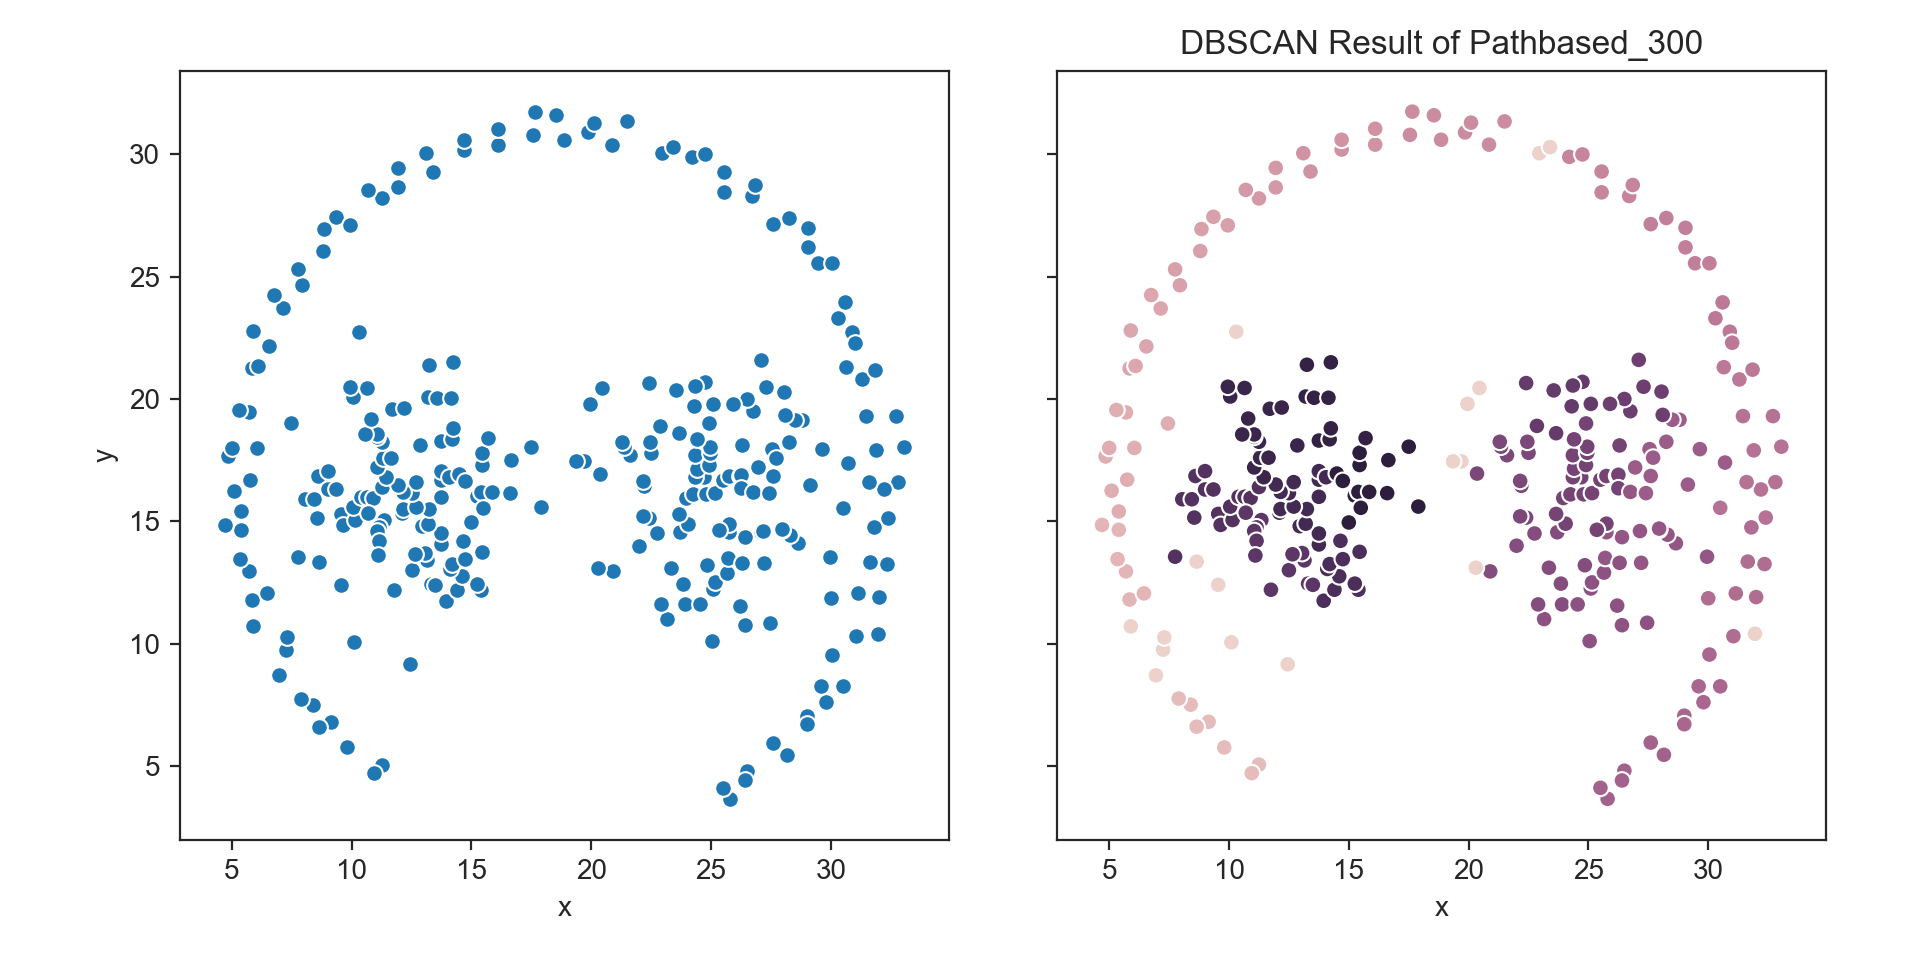

eps: 1.8 min points: 6 silhouette coefficient: 0.38439135919352124


0.38439135919352124

In [110]:
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
plot_result(dataset, result_tags, 'Pathbased_300')
Evaluation.silhouette_coefficient(mdbscan)

In [112]:
test_file = '../../data/shape-sets/spiral.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [4, 4], [4, 8]]
eps = 3.5
min_pts = 2
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

# serial naive
print('\nSERIAL:')
mdbscan = NaiveDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()

print('\nSERIAL:')
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
# Evaluation.silhouette_coefficient(mdbscan)

for n_partitions in n_partition_set:
    print(f'\nPartitions: {np.prod(n_partitions)}')
    # parallel naive dbscan
    print('\nNAIVE:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='naive', metric='euclidian')

    # parallel matrix dbscan
    print('\nMATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='euclidian')

    # parallel matrix dbscan
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian')



SERIAL:
predict time cost: 1181.793ms

SERIAL:
predict time cost: 573.596ms

Partitions: 4

NAIVE:
partition time cost: 17.856ms
merge time cost: 3.668ms
parallel_dbscan time cost: 716.784ms

MATRIX:
partition time cost: 17.371ms
merge time cost: 5.572ms
parallel_dbscan time cost: 231.816ms

FAST-MATRIX:
partition time cost: 19.734ms
merge time cost: 4.554ms
parallel_dbscan time cost: 235.659ms

Partitions: 8

NAIVE:
partition time cost: 24.633ms
merge time cost: 5.245ms
parallel_dbscan time cost: 548.656ms

MATRIX:
partition time cost: 20.211ms
merge time cost: 5.297ms
parallel_dbscan time cost: 207.717ms

FAST-MATRIX:
partition time cost: 21.002ms
merge time cost: 5.279ms
parallel_dbscan time cost: 214.695ms

Partitions: 16

NAIVE:
partition time cost: 32.864ms
merge time cost: 8.017ms
parallel_dbscan time cost: 484.537ms

MATRIX:
partition time cost: 29.716ms
merge time cost: 8.911ms
parallel_dbscan time cost: 218.781ms

FAST-MATRIX:
partition time cost: 32.126ms
merge time cost: 8

predict time cost: 580.972ms


<IPython.core.display.Javascript object>


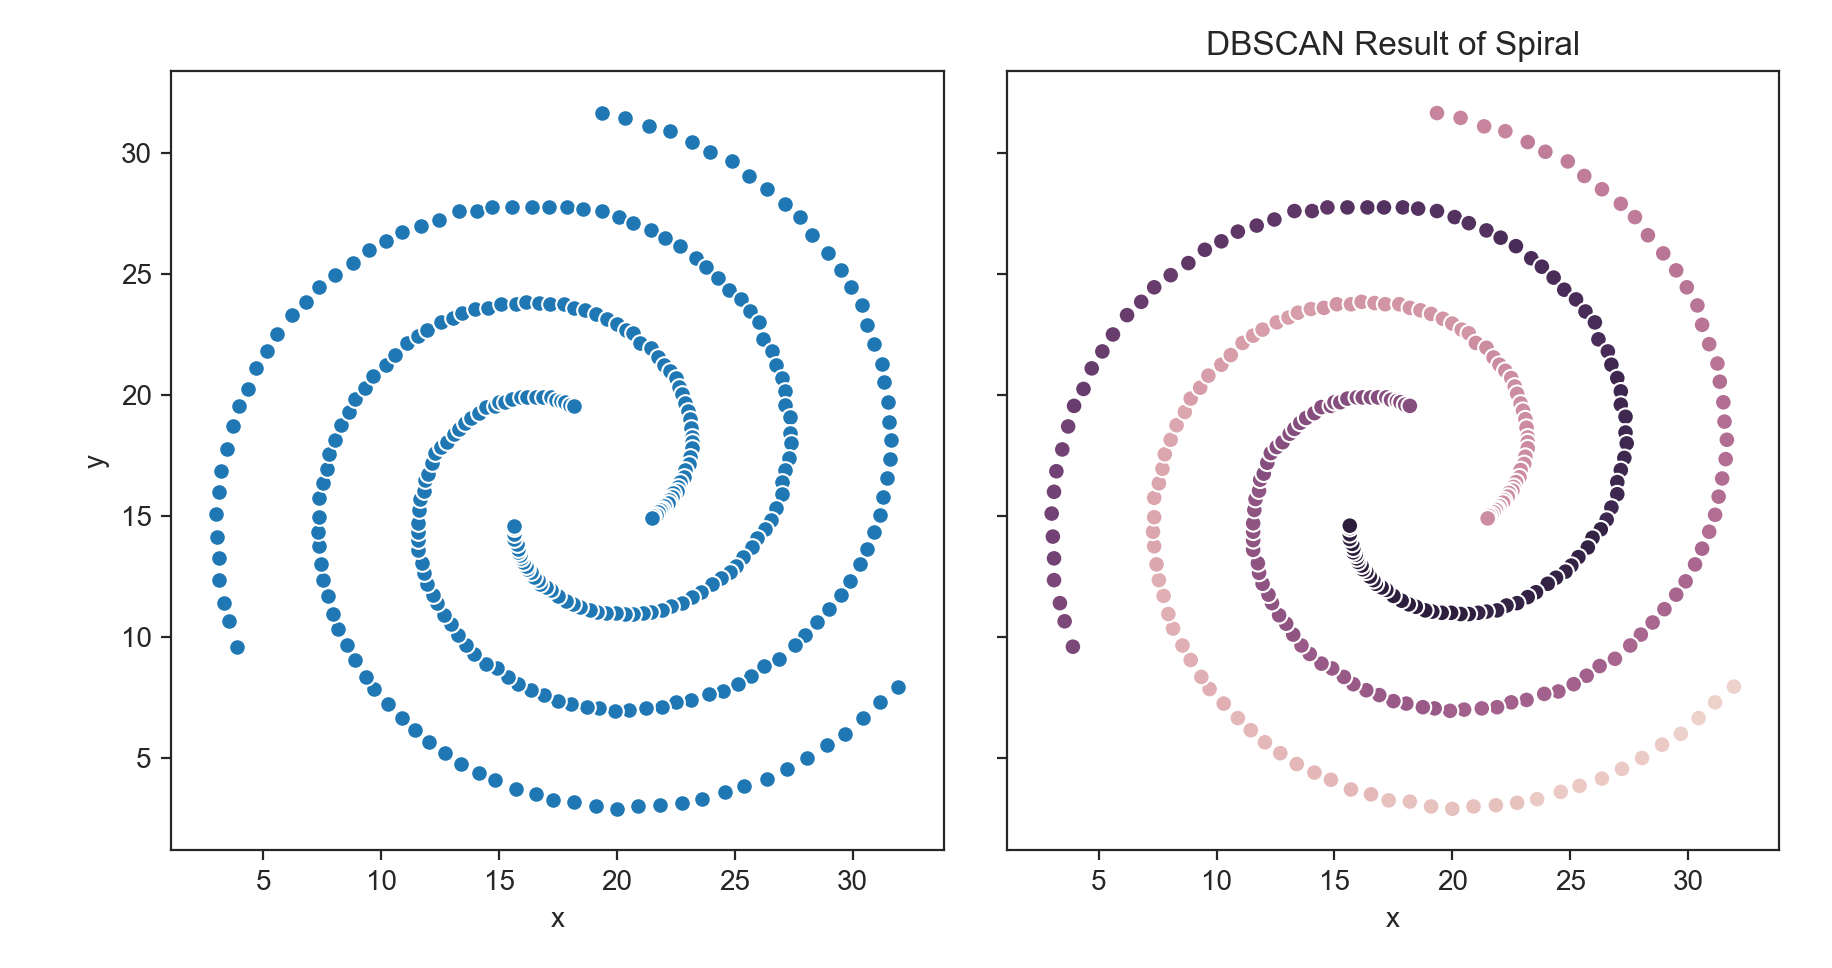

eps: 3.5 min points: 2 silhouette coefficient: 0.4661964889068999


0.4661964889068999

In [94]:
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
plot_result(dataset, result_tags, 'Spiral')
Evaluation.silhouette_coefficient(mdbscan)